<div style="text-align: center;">
  <a href="https://cognitiveclass.ai/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="400">
  </a>
</div>


<h1 align=left><font size = 6>Lab: Train and Evaluate a Keras-Based Classifier </font></h1>


<h5>Estimated time: 90 minutes</h5>


<h2>Objective</h2>


After completing this lab, you will be able to:
<ul> 
    
1. Create a Keras-based convolutional neural network (CNN) model.
2. Train the CNN model on agricultural and non-agricultural land dataset.
3. Evaluate the performance of the CNN model. 
    
</ul> 


## Introduction

This notebook demonstrates the process of building, training, and evaluating a **Keras-based convolutional neural network (CNN)** for image classification, for agricultural images in our case. This lab will cover the following:
1. Data preparation
2. Model architecture definition
3. Training
4. Model performance analysis.

The goal is to classify satellite images into two categories: "agricultural" and "non-agricultural"


## Table of Contents
<font size = 3> 

1. [Configuration and library imports](#Configuration-and-library-imports)
2. [Data acquisition and preparation](#Data-acquisition-and-preparation)
3. [Model definition and compilation](#Model-definition-and-compilation)
4. [Model training](#Model-training)
5. [Download and save the model](#Download-and-save-the-trained-model)
6. [Model evaluation and visualization](#Model-evaluation-and-visualization)

</font>


## Configuration and library imports


### Install required libraries

Some of the required libraries are __not__ pre-installed in the Skills Network Labs environment. You must run the following cell to install them; it might take a few minutes for the installation.


In [1]:
# define a function to check for successful installation of the libraries
def lib_installation_check(captured_data, n_lines_print):
    """
    A function to use the %%capture output from the cells where we try to install the libraries.
    It would print last "n_lines_print" if there is an error in library installation
    """
    output_text = captured_data.stdout
    lines = output_text.splitlines()
    output_last_n_lines = '\n'.join(lines[-n_lines_print:])
    if "error" in output_last_n_lines.lower():
        print("Library installation failed!")
        print("--- Error Details ---")
        print(output_last_n_lines)
    else:
        print("Library installation was successful, let's proceed ahead")    

### Library installation - 1


Next, let’s install the non-AI libraries.


In [2]:
%%time
%%capture captured_output
%pip install numpy==1.26
%pip install matplotlib==3.9.2
%pip install skillsnetwork

CPU times: user 15.6 ms, sys: 20.6 ms, total: 36.2 ms
Wall time: 4.05 s


Now, check if the above libraries are installed properly.


In [3]:
lib_installation_check(captured_data = captured_output, n_lines_print = 5)

Library installation was successful, let's proceed ahead


### `TensorFlow` library installation


Next, install the `TensorFlow` library using the code below. 


In [4]:
%%time
%pip install tensorflow==2.19

Note: you may need to restart the kernel to use updated packages.
CPU times: user 22.2 ms, sys: 10.1 ms, total: 32.3 ms
Wall time: 1.51 s


### `scikit-learn` library installation


Install the scikit-learn library. 


In [5]:
%pip install scikit-learn==1.7.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 189.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 154.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.4.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


### Import libraries


Import the non-AI libraries. 


In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import os
import sys
import time
import shutil
import random
import numpy as np
import skillsnetwork
from tqdm import tqdm
import matplotlib.pyplot as plt

### TensorFlow environment configuration

This cell sets environment variables for TensorFlow. 
- `TF_ENABLE_ONEDNN_OPTS` is set to "0" to disable Intel oneDNN optimizations, which can sometimes lead to issues or unwanted behavior on specific hardware configurations.
- `TF_CPP_MIN_LOG_LEVEL` is set to "2," instructing TensorFlow to only display warning and error messages from its C++ backend. This reduces verbose output and keeps the console cleaner, focusing on more critical information during model training.


In [8]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Next, set up the data extraction directory.


In [9]:
extract_dir = "."

## Data acquisition and preparation

### Define the dataset URL


We define the `url` that holds the link to the dataset. The dataset is a `.tar` archive hosted on a cloud object storage service. Cloud object storage (such as S3) is a highly scalable and durable way to store and retrieve large amounts of unstructured data.


In [10]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar"

### Download the data

1. Download and extract data from the cloud using `skillsnetwork.prepare` method.
2. Use a fallback method if the `skillsnetwork.prepare` command fails to download and extract the dataset. The fallback involves asynchronously downloading the `.tar` file using `httpx` and then extracting its contents using the `tarfile` library.
3. The `tarfile` module provides an interface to tar archives, supporting various compression formats such as gzip and bzip2 (handled by `r:*` mode).


In [11]:
def check_skillnetwork_extraction(extract_dir):
    """ function to check whether data download and extraction method 
    `skillsnetwork.prepare` would execute successfully, without downloading any data.
    This helps in early detection and fast fallback to explicit download and extraction
    using default libraries
    ###This is a hack for the code to run on non-cloud computing environment without errors
    """
    symlink_test = os.path.join(extract_dir, "symlink_test")
    if not os.path.exists(symlink_test):
        os.symlink(os.path.join(os.sep, "tmp"), symlink_test) 
        print("Write permissions available for downloading and extracting the dataset tar file")
    os.unlink(symlink_test)

async def download_tar_dataset(url, tar_path, extract_dir):
    """function to explicitly download and extract the dataset tar file from cloud using native python libraries
    """
    if not os.path.exists(tar_path): # download only if file not downloaded already
        try:
            print(f"Downloading from {url}...")
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)# Download the file asynchronously
                response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)
            
                with open(tar_path , "wb") as f:
                    f.write(response.content) # Save the downloaded file
                print(f"Successfully downloaded '{file_name}'.")
        except httpx.HTTPStatusError as http_err:
            print(f"HTTP error occurred during download: {http_err}")
        except Exception as download_err:
            print(f"An error occurred during the fallback process: {download_err}")
    else:
        print(f"dataset tar file already downloaded at: {tar_path}")
    with tarfile.open(tar_path, 'r:*') as tar_ref:
        tar_ref.extractall(path=extract_dir)
    print(f"Successfully extracted to '{extract_dir}'.")
            


In [12]:
try:
    check_skillnetwork_extraction(extract_dir)
    await skillsnetwork.prepare(url = url, path = extract_dir, overwrite = True)
except Exception as e:
    print(e)
    # --- FALLBACK METHOD FOR DOWNLOADING THE DATA ---
    print("Primary download/extration method failed.")
    print("Falling back to manual download and extraction...")
    
    # import libraries required for downloading and extraction
    import tarfile
    import httpx 
    from pathlib import Path
    
    file_name = Path(url).name# Get the filename from the URL (for example, 'data.tar')
    tar_path = os.path.join(extract_dir, file_name)
    print(f"tar_path: {os.path.exists(tar_path)} ___ {tar_path}")
    await download_tar_dataset(url, tar_path, extract_dir)

Write permissions available for downloading and extracting the dataset tar file


  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to '.'


### Import deep learning and ML libraries

Here is a brief description of the usage of the **Keras** libraries and methods that will be used:
- `Sequential` models are a linear stack of layers.
- `Conv2D` and `MaxPooling2D` are fundamental for CNNs, extracting features and reducing dimensionality.
- `BatchNormalization` stabilizes training.
- `Dense` layers form the classifier.
- `Dropout` regularizes to prevent overfitting.
- `Adam` is an adaptive learning rate optimizer.
- `ImageDataGenerator` automates data loading and augmentation.
- `HeUniform` is used for weight initialization.


**Scikit-learn** (`sklearn.metrics`) provides the following metrics for model performance assessment: 
- `classification_report`
- `confusion_matrix`
- `accuracy_score`


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score
print("Succesfully imported the libraries")

E0000 00:00:1771361445.932015     813 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771361445.938726     813 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771361445.954428     813 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771361445.954449     813 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771361445.954451     813 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771361445.954453     813 computation_placer.cc:177] computation placer already registered. Please check linka

Succesfully imported the libraries


### Get the processing device
Check the availability of GPU


In [14]:
gpu_list = tf.config.list_physical_devices('GPU')

device = "gpu" if gpu_list !=[] else "cpu"
print(f"Device available for training: {device}")

Device available for training: cpu


### Reproducibility with random seeds

Here we fix the random seeds for `random` module, NumPy, and TensorFlow. By initializing these seeds with a constant value (for example, 42), any operations that involve randomness (such as weight initialization, data shuffling, or data augmentation) will produce the exact same sequence of random numbers every time the code is run. This is crucial for ensuring the reproducibility of experimental results and when comparing different models or hyperparameters.


In [15]:
# Set seed for reproducibility
seed_value = 7331
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

### Define the dataset path


In [16]:
dataset_path = os.path.join(extract_dir, "images_dataSAT")
print(dataset_path)

./images_dataSAT


### Create the dataset file list


Now that we have downloaded the dataset, perform the following task. 


### **Task 1:** Recursively walk through the `dataset_path` using `os.walk` function to create a list **`fnames`** of all image files. 
Print the total count of files found and displays the first two and last two file paths. 

Absolute path is captured using `os.path.join(dirname, filename)` and used in `ImageDataGenerator` later.


In [17]:
## You can use this cell to type the code to complete the task.

fnames = []
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        fnames.append(os.path.join(dirname, filename))

print(f"total files in dataset: {len(fnames)}")
nfname_print=2
for f in fnames[:nfname_print]:
    print(f)
for f in fnames[-nfname_print:]:
    print(f)
    

total files in dataset: 6000
./images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_15431.jpg
./images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_14713.jpg
./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_12587.jpg
./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_3371.jpg


Double-click **here** for the solution.
<!-- The correct answer is:


fnames = []
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        fnames.append(os.path.join(dirname, filename))
print(f"total files in dataset: {len(fnames)}")
nfname_print=2
for f in fnames[:nfname_print]:
    print(f)
for f in fnames[-nfname_print:]:
    print(f)

-->


### Define the model hyperparameters

Hyperparameters are configurable values that are set before the training process begins. 

This cell initializes several key hyperparameters that will govern the training process and the model's input. Here is the list of hyperparameters:

1. `img_w` and `img_h` define the width and height for resizing input images.
2. `n_channels` defines the number of color channels (3 for RGB).
3. `n_epochs` sets the total training iterations over the dataset.
4. `batch_size` sets the number of samples processed per batch in the epoch.
5. `lr` defines the learning rate for the optimizer.
6. `steps_per_epoch` are total number of steps used for training. **None** means the number is calculated automatically.
7. `validation_steps` are total number of steps used for validating the model on validation data. **None** means the number is calculated automatically.

These hyperparameters are crucial for controlling model performance and resource utilization and significantly influence a model's performance and training efficiency. 


In [18]:
img_w, img_h = 64, 64
n_channels = 3
batch_size = 128
lr = 0.001 # Learning rate
n_epochs = 3 # set to low number for your convenience. You can change this to any number of your liking

steps_per_epoch = None
validation_steps = None 

model_name = "ai_capstone_keras_best_model.model.keras"

### Configure `ImageDataGenerator` for Augmentation


Now, we instantiate the `ImageDataGenerator` with data augmentation parameters:

- `rescale=1./255` normalizes pixel values to [0, 1].
- `rotation_range`, `width_shift_range`, `height_shift_range`, `shear_range`, and `zoom_range` define random transformations to apply to images during training, increasing dataset diversity.
- `horizontal_flip=True` enables random horizontal mirroring.
- `fill_mode='nearest'` specifies how new pixels are filled after transformations.
- `validation_split=0.2` reserves 20% of data for validation.


This setup boosts model robustness against variations in real-world images. `ImageDataGenerator` performs these transformations on-the-fly, making it efficient for large datasets. 


In [19]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=40, 
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest",
                             validation_split=0.2
                            )

### Create training and validation data generators

 `ImageDataGenerator` is used to create `train_generator` and `validation_generator`. 
`flow_from_directory()` is a convenient method of `ImageDataGenerator` for automatically creating data pipelines from structured image directories.
 The generator resize images to `(img_w, img_h)` and group them into `batch_size` chunks. `class_mode="binary"` indicates a two-class classification task. 
 
 The `subset` parameter is used to assign 80% of the data for training and 20% for validation based on the `validation_split`. 


In [20]:
train_generator = datagen.flow_from_directory(dataset_path,
 target_size = (img_w, img_h),
 batch_size= batch_size,
 class_mode="binary",
 subset="training"
 )

Found 4800 images belonging to 2 classes.


Here is your next task. We have created the `train_generator`, let's create the `validation_generator`.


### **Task 2:** Create the `validation_generator` from `dataset_path`.
Use `target_size`, and `class_mode` similar to `train_generator`.


In [21]:
## You can use this cell to type the code to complete the task.


validation_generator = datagen.flow_from_directory(dataset_path,
                                                    target_size =(img_w, img_h),
                                                    batch_size = batch_size, 
                                                    class_mode="binary",
                                                    subset="validation"
                                                    )



Found 1200 images belonging to 2 classes.


Double-click **here** for the solution.
<!-- The correct answer is:
validation_generator = datagen.flow_from_directory(dataset_path,
                                                    target_size =(img_w, img_h),
                                                    batch_size = batch_size, 
                                                    class_mode="binary",
                                                    subset="validation"
                                                    )

-->


## Model definition and compilation

### Define the convolutional neural network (CNN) architecture

The model architecture is composed of several key components:
- **`Sequential`** is a linear stack of layers in Keras.
- **Conv2D** layers perform convolution operations, acting as feature detectors.
- **MaxPooling2D** reduces the spatial dimensions of the feature maps.
-  **BatchNormalization** normalizes layer inputs, stabilizing and accelerating training.
-  **GlobalAveragePooling2D** summarizes feature maps into a single vector, reducing parameters.
-  **Dense** (fully connected) layers learn complex patterns from these features.
-  **Dropout** is a regularization technique that randomly deactivates neurons during training.
-  **Sigmoid** activation is used for binary classification, mapping outputs to probabilities.
-  **HeUniform** initializer is suitable for ReLU activations.
-  **The final output `Dense` layer** uses a `sigmoid` activation for binary classification, outputting a probability between 0 and 1.


In [22]:
model = Sequential([
                    Conv2D(32 , (5,5) , activation="relu",padding="same",strides=(1,1), kernel_initializer=HeUniform(), input_shape=(img_w, img_h, n_channels)),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(64, (5,5) , activation="relu",padding="same" , strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(128, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    ###
                    Conv2D(256, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(512, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(1024, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    
                    ###
                    GlobalAveragePooling2D(),
                    
                    Dense(64,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(128,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(256,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    ###
                    Dense(512,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(1024,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(2048,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    
                    ###
                    Dense(1 , activation="sigmoid")
                    
                ])

### Compile the model and display the summary


Here, we compile the model using `model.compile()` with the `Adam` optimizer and `learning_rate` equal to `lr` (0.001). 

The `loss` function is specified as `"binary_crossentropy"`, appropriate for binary classification problems. 
`accuracy` is set as the performance `metric` to monitor training and evaluation. 
We print `model.summary()` for a detailed overview of the network


In [23]:
loss = "binary_crossentropy"
model.compile(optimizer=Adam(learning_rate=lr),
              loss=loss, 
              metrics=["accuracy"])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 1024)     │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 20,352,897 (77.64 MB)

 Trainable params: 20,340,801 (77.59 MB)

 Non-trainable params: 12,096 (47.25 KB)

None


Answer the question below in the space provided. 


## Question: Count the total number of layers in this CNN model?


### You can use this cell to type the answer to the question.


There are total of 38 Layers. 

Double-click **here** for the solution.
<!-- The correct answer is:
There are total 38 layers.
-->


You now know how to create a CNN model using Keras. You can perform the following task. 


## Task 3: Create and compile a CNN model `test_model` with 4 Conv2D layers and 5 Dense layers.


In [24]:
## You can use this cell to type the code to complete the task.

absmodel = Sequential([
 Conv2D(32 , (5,5) , activation="relu",padding="same",strides=(1,1), kernel_initializer=HeUniform(), input_shape=(img_w, img_h, n_channels)),
 MaxPooling2D(2,2),
 BatchNormalization(),

 Conv2D(64, (5,5) , activation="relu",padding="same" , strides=(1,1), kernel_initializer=HeUniform()),
 MaxPooling2D(2,2),
 BatchNormalization(),

 Conv2D(128, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
 MaxPooling2D(2,2),
 BatchNormalization(),
 

 Conv2D(256, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
 MaxPooling2D(2,2),
 BatchNormalization(),
 

 GlobalAveragePooling2D(),

 Dense(64,activation="relu" , kernel_initializer=HeUniform()),
 BatchNormalization(),
 Dropout(0.4),

 Dense(128,activation="relu" , kernel_initializer=HeUniform()),
 BatchNormalization(),
 Dropout(0.4),

 Dense(256,activation="relu" , kernel_initializer=HeUniform()),
 BatchNormalization(),
 Dropout(0.4),


 Dense(512,activation="relu" , kernel_initializer=HeUniform()),
 BatchNormalization(),
 Dropout(0.4),


 Dense(1 , activation="sigmoid")
 
 ])


loss = "binary_crossentropy"
model.compile(optimizer=Adam(learning_rate=lr),loss=loss, metrics=["accuracy"])



Double-click **here** for the solution.
<!-- The correct answer is:
model = Sequential([
 Conv2D(32 , (5,5) , activation="relu",padding="same",strides=(1,1), kernel_initializer=HeUniform(), input_shape=(img_w, img_h, n_channels)),
 MaxPooling2D(2,2),
 BatchNormalization(),

 Conv2D(64, (5,5) , activation="relu",padding="same" , strides=(1,1), kernel_initializer=HeUniform()),
 MaxPooling2D(2,2),
 BatchNormalization(),

 Conv2D(128, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
 MaxPooling2D(2,2),
 BatchNormalization(),
 
###
 Conv2D(256, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
 MaxPooling2D(2,2),
 BatchNormalization(),
 
###
 GlobalAveragePooling2D(),

 Dense(64,activation="relu" , kernel_initializer=HeUniform()),
 BatchNormalization(),
 Dropout(0.4),

 Dense(128,activation="relu" , kernel_initializer=HeUniform()),
 BatchNormalization(),
 Dropout(0.4),

 Dense(256,activation="relu" , kernel_initializer=HeUniform()),
 BatchNormalization(),
 Dropout(0.4),

###
 Dense(512,activation="relu" , kernel_initializer=HeUniform()),
 BatchNormalization(),
 Dropout(0.4),

###
 Dense(1 , activation="sigmoid")
 
 ])

# Compile the model to make it ready for training
loss = "binary_crossentropy"
model.compile(optimizer=Adam(learning_rate=lr),loss=loss, metrics=["accuracy"])

-->


## Model training

### Display the training configuration and hyperparameters

Here we print a comprehensive summary of the training configuration and list all critical hyperparameters. This detailed output serves as a quick reference and verification of the experimental setup.
Before commencing computationally intensive tasks such as deep learning model training, it's a good practice to log and verify the configuration.


In [25]:
print(f"Training Hyperparameters:\n\
        n_classes (train) = {train_generator.num_classes},\n\
        n_classes (validation) = {validation_generator.num_classes},\n\
        img_w, img_h ={img_w, img_h},\n\
        n_channels = {n_channels},\n\
        batch_size = {batch_size},\n\
        steps_per_epoch = {steps_per_epoch},\n\
        n_epochs = {n_epochs},\n\
        validation_steps = {validation_steps},\n\
        learning_rate = {lr}")

Training Hyperparameters:
        n_classes (train) = 2,
        n_classes (validation) = 2,
        img_w, img_h =(64, 64),
        n_channels = 3,
        batch_size = 128,
        steps_per_epoch = None,
        n_epochs = 3,
        validation_steps = None,
        learning_rate = 0.001


### Save the model checkpoint

Now we declare a method to save the **best model** during training. The best model can be defined by either **lowest loss** or **high accuracy**.


In [26]:
# Create the ModelCheckpoint callback
checkpoint_cb = ModelCheckpoint(filepath=model_name,
                                monitor='val_loss',      # or 'val_accuracy'
                                mode='min',              # 'min' for loss, 'max' for accuracy
                                save_best_only=True,
                                verbose=1
                               )

The checkpoint of a model can also be based on high accuracy. So, here's your next task.  


### **Task 4**: Create the checkpoint callback for model with **maximum accuracy**. 


In [27]:
## You can use this cell to type the code to complete the task.

checkpoint_cb = ModelCheckpoint(filepath=model_name,
                                monitor='val_accuracy',
                                mode='max',
                                save_best_only=True,
                                verbose=1
                               )



Double-click **here** for the solution.
<!-- The correct answer is:
checkpoint_cb = ModelCheckpoint(filepath=model_name,
                                monitor='val_accuracy',
                                mode='max',
                                save_best_only=True,
                                verbose=1
                               )


-->


### Execute model training

- `model.fit()` is the primary function for training a Keras model. It controls the entire training loop: iterating over epochs, fetching data batches from generators, performing forward and backward passes, updating weights via the optimizer, and calculating loss and metrics.
- `steps_per_epoch` (*if specified*) determines how many batches constitute an "epoch."
- `validation_data` and `validation_steps` allow monitoring of the model's generalization ability on a separate dataset, helps in detecting overfitting.
- `callbacks` determines how the best model is saved.
- The `fit` object stores the model's training history.


In [28]:
print(f"Training on : ==={device}=== with batch size: {batch_size} & lr: {lr}")

fit = model.fit(train_generator, 
                epochs= n_epochs,
                steps_per_epoch = steps_per_epoch,
                validation_data=(validation_generator),
                validation_steps = validation_steps,
                callbacks=[checkpoint_cb],
                verbose=1
               )

Training on : ===cpu=== with batch size: 128 & lr: 0.001
Epoch 1/3
13/38 ━━━━━━━━━━━━━━━━━━━━ 21:44 52s/step - accuracy: 0.6240 - loss: 0.7948

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
FileNotFoundError: [Errno 2] No such file or directory: './images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_2149.jpg'
Traceback (most recent call last):

  File "/opt/conda/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/opt/conda/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/opt/conda/lib/python3.12/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 264, in _finite_generator
    yield self._standardize_batch(self.py_dataset[i])
                                  ~~~~~~~~~~~~~~~^^^

  File "/opt/conda/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py", line 71, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/conda/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py", line 316, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
          ^^^^^^^^^^^^^^^^^^^^^

  File "/opt/conda/lib/python3.12/site-packages/keras/src/utils/image_utils.py", line 247, in load_img
    with open(path, "rb") as f:
         ^^^^^^^^^^^^^^^^

FileNotFoundError: [Errno 2] No such file or directory: './images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_2149.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_11110]

## Download and save the trained model


After the training is completed, you will see `ai_capstone_keras_best_model.model.keras` in the left pane

**However**, for your convenience, I have saved a model trained over 20 epochs **[here](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/f63OXPboUBgVhDpozcJZ3w/ai-capstone-keras-best-model-model.keras)**. You can download that for evaluation and further labs on your local machine from **[this link](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/f63OXPboUBgVhDpozcJZ3w/ai-capstone-keras-best-model-model.keras)**.


This is the Keras AI model created by training on the provided dataset for agricultural and non-agricultural land dartaset. This model can now be used for infering un-classified images with the dimensions similar to the training images. 

- You can also download the your trained model file: `ai_capstone_keras_best_model.model.keras` from the left pane and save it on your local computer. 
- You can download this model by "right-click" on the file and then Clickinng "Download".
- You could use this model for the other labs of this capstone project course.


Please refer to the screenshots below for downloading the model to your local computer.


### The trained model file (`ai_capstone_keras_best_model.model.keras` ) in the left pane
![Model_Keras_download_screenshot_1_marked.png](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/NM4wJ1o8G3f0Gv3Ic_cHOQ/Model-Keras-download-screenshot-1-marked.png)


### The **download** option
![Model_Keras_download_screenshot_2_marked.png](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/y4ubxvX6OHSWP9KvB-fzHQ/Model-Keras-download-screenshot-2-marked.png)


## Model evaluation and visualization


### Perform a comprehensive model evaluation

Here, you will perform a detailed evaluation of the trained model on the validation dataset. You would calculate the necessary prediction `steps` based on the validation data and `batch_size`. Then, you will obtain the true class labels (`y_true`) and generate the model's predictions (`y_pred`) on the validation set. The predicted probabilities are converted to binary class labels using a 0.5 threshold. Finally, you will print the overall `accuracy_score`, to get a  quantitative assessment of the model's performance on unseen data.

Model evaluation metrics are essential for understanding a model's generalization ability. `y_true` represents the actual labels, while `y_pred` are the model's predicted labels. For binary classification, probabilities are converted to class labels by thresholding. The **accuracy score** is the proportion of correct predictions out of the total predictions.


In [29]:
steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))
batch_size = int(validation_generator.batch_size)

all_preds = []
all_labels = []
for step in range(steps):
    # Get one batch data
    images, labels = next(validation_generator)
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int).flatten() 
    all_preds.extend(preds)
    all_labels.extend(labels)
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy Score: {accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step
Accuracy Score: 0.5467


### Visualize the training history (accuracy and loss)


This cell generates two plots to visualize the model's training performance, one for accuracy and one for loss, across epochs. 
- **Accuracy** measures the proportion of correct predictions. 
- **Loss** quantifies the error between predictions and true labels. 
- Using these metrics, we can check the model for **overfitting** or **underfitting**. 
- `fit.history` attribute stores these metrics for each epoch.


NameError: name 'fit' is not defined

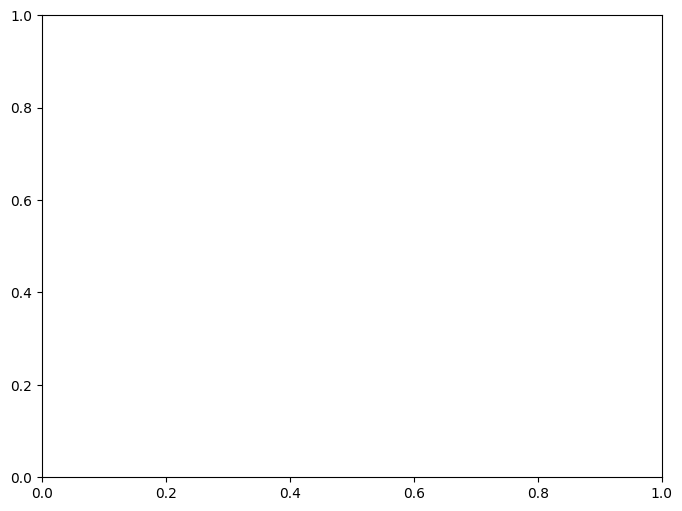

In [30]:
# Create a figure with a subplot
fig, axs = plt.subplots(figsize=(8, 6))

# Plot Accuracy on the first subplot
axs.plot(fit.history['accuracy'], label='Training Accuracy')
axs.plot(fit.history['val_accuracy'], label='Validation Accuracy')
axs.set_title('Model Accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Accuracy')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

Plot the model loss in the task below. 


### **Task 5:** Plot the graph for **training loss** and **validation loss** for the model `fit`.


NameError: name 'fit' is not defined

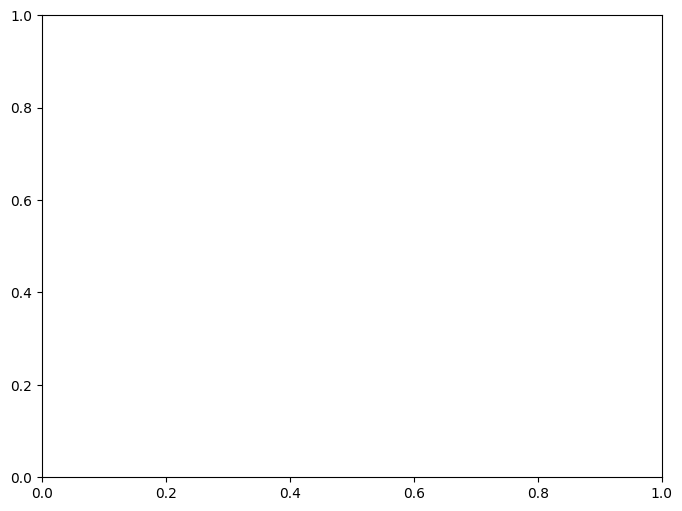

In [31]:
## You can use this cell to type the code to complete the task.

fig, axs = plt.subplots( figsize=(8, 6))



axs.plot(fit.history['loss'], label='Training Loss')
axs.plot(fit.history['val_loss'], label='Validation Loss')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)


plt.tight_layout()
plt.show()



Double-click **here** for the solution.
<!-- The correct answer is:

fig, axs = plt.subplots( figsize=(8, 6))


# Plot Loss on the second subplot
axs.plot(fit.history['loss'], label='Training Loss')
axs.plot(fit.history['val_loss'], label='Validation Loss')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()
-->


## Save and download the notebook for **final project** submission and evaluation

You will need to save and download the completed notebook for final project submission and evaluation. 
<br>For saving and downloading the completed ntoebook, please follow the steps given below:</br>

<font size = 4>  

1) **Complete** all the tasks and questions given in the notebook.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/nv4jHlPU5_R1q7ZJrZ69eg/DL0321EN-M1L1-Save-IPYNB-Screenshot-1.png" style="width:600px; border:0px solid black;">

2) **Save** the notebook.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9-WPWD4mW1d-RV5Il5otTg/DL0321EN-M1L1-Save-IPYNB-Screenshot-2.png" style="width:600px; border:0px solid black;">

3) Identify and right click on the **correct notebook file** in the left pane.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/RUSRPw7NT6Sof94B7-9naQ/DL0321EN-M1L1-Save-IPYNB-Screenshot-3.png" style="width:600px; border:0px solid black;">

4) Click on **Download**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/HHry4GT-vhLEcRi1T_LHGg/DL0321EN-M1L1-Save-IPYNB-Screenshot-4.png" style="width:600px; border:0px solid black;">

5) Download and **Save** the Jupyter notebook file on your computer **for final submission**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/hhsJbxc6R-T8_pXQGjMjvg/DL0321EN-M1L1-Save-IPYNB-Screenshot-5.png" style="width:600px; border:0px solid black;">
  </font>


## Conclusion
Congratulation! You've successfully bulit, trained, and evaluated a deep learning model using Keras for image classification.

- **Robust data handling:** We implemented a robust data acquisition strategy, featuring a primary method and a crucial fallback for reliable data downloading and extraction.
- **Reproducibility:** We used fixed random seeds ensures your results are consistent and verifiable across multiple runs.
- **Data generators:** We learnt about ImageDataGenerator for efficient on-the-fly image loading, resizing, normalization, and vital data augmentation.
- **CNN architecture:** We built a multi-layered CNN, incorporating Conv2D, MaxPooling2D, BatchNormalization, Dropout, and Dense layers for effective feature learning and classification.
- **Model compilation:** We configured the model's learning process with an Adam optimizer, binary_crossentropy loss, and accuracy metric.
- **Training process:** We executed the training loop, feeding data in batches and monitoring performance over epochs.
- **Performance visualization:** We plotted the accuracy and loss plots for understandinbg the model's learning progress and identify overfitting.
- **Model evaluation:** Finally, we use accuracy_score for a quantitative assessment of your model.


<h2>Author</h2>

[Aman Aggarwal](https://www.linkedin.com/in/aggarwal-aman)

Aman Aggarwal is a PhD working at the intersection of neuroscience, AI, and drug discovery. He specializes in quantitative microscopy and image processing.



<!--
## Change Log

'''|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
```
```|---|---|---|---|
```
```| 2025-06-21  | 1.0  | Aman  |  Created the lab |
```
```| 2025-06-30  | 2.0  | Sangeeta |  ID review |
```
-->


© Copyright IBM Corporation. All rights reserved.
